# Radial mode regression

## Contents
* [Task description](#Task-description)
* [Dataset preprocessing](#Dataset-preprocessing)
* [Models architecture](#Models-architecture)
* [Training](#Training)
* [Models evaluation](#Model-evaluation)
* [Examples](#Examples)
    * [Best predictions](#Best-predictions)
    * [Worst predictions](#Worst-predictions)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

## Task description
To predict a position of the radial mode according to the pressure derivative vs time data.

## Dataset preprocessing

For training and model performance assessment we use pressure derivative from wells.

Dataset consists of two parts: train (311 files) and test (90 files) in `npz` format.

Each one consists of:
* `derivative` - an array of the pressure derivative of different length
* `time` - an array of times when the above measurements were taken
* `target` - a position of the radial mode

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(".."))

import numpy as np
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, B
from radial.batchflow.models.tf import ResNet, TFModel

from radial.batchflow.research import Research
from radial.core import RadialBatch, draw_predictions, calculate_results
from radial.pipelines import *

from research_utils import print_results_research, draw_hisogram

plt.style.use('ggplot')
%matplotlib inline

Contents of one item from dataset saved in `npz` files:

In [2]:
example_data = np.load('../radial/tests/data/rr_0.npz')
print("npz file contains {} pieces of data:".format(len(example_data.files)))
for data in example_data.files:
    print("* '{}'\n   shape - {}, dtype - {}, data - {!r:.40}{}".format(data,
                                                                        example_data[data].shape,
                                                                        example_data[data].dtype,
                                                                        example_data[data],
                                                                        ('...])' 
                                                                         if data!='target'
                                                                         else '')))

npz file contains 3 pieces of data:
* 'time'
   shape - (388,), dtype - float64, data - array([2.20912736e+00, 4.88164911e+00, 7...])
* 'derivative'
   shape - (388,), dtype - float64, data - array([  40.56873186,   70.49161323,   9...])
* 'target'
   shape - (), dtype - float64, data - array(683.91164728)


Create `Barchflow's` `dataset` class instance to load all data.

In [3]:
train_data = Dataset(FilesIndex(path="./data_splited/train/*"), batch_class=RadialBatch)
test_data = Dataset(FilesIndex(path="./data_splited/test/*"), batch_class=RadialBatch)

In [4]:
sample_data = train_data.p.load(fmt='npz').next_batch(10)

Some examples of the initial data

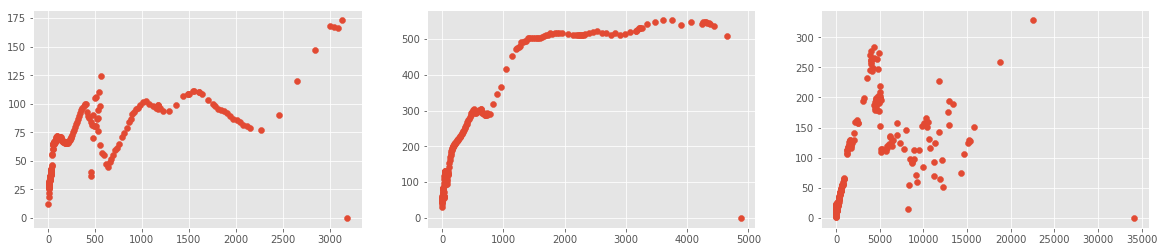

In [5]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

Pressure derivative data is noisy so we denoised the data beforehand using unsupervised method [Isolation forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

In [6]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)
sample_data = ds_train.p.load(fmt='npz').next_batch(10)

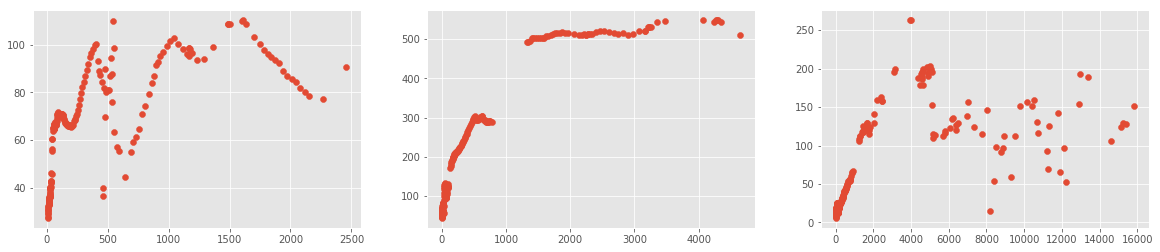

In [7]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

As you can see algorithm removed some of the single distant outliers that are not informative.

Distribution of radial mode value for train and test data:

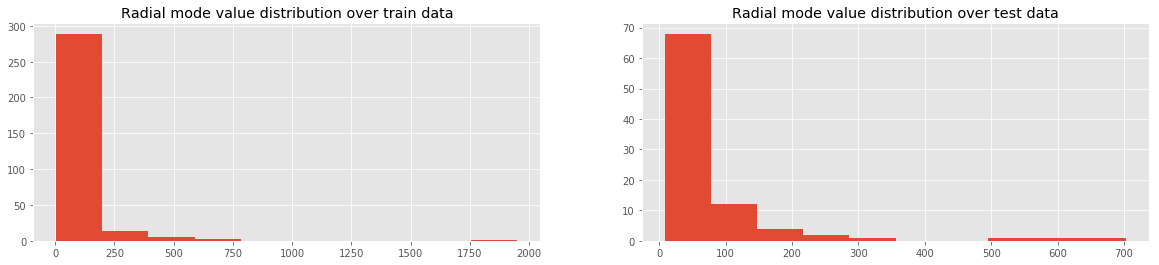

In [8]:
train = ds_train.p.load(fmt='npz').next_batch(len(ds_train))
test = ds_train.p.load(fmt='npz').next_batch(len(ds_test))

_, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].hist(train.target)
ax[0].set_title("Radial mode value distribution over train data")
ax[1].hist(test.target)
ax[1].set_title("Radial mode value distribution over test data")
plt.show()

Scale of the pressure derivative (and consequently the radial mode values) is different across different wells. Therefore in preprocessing pipeline we
normalize the pressure derivative data, time and radial mode value to the range [0, 1] by substracting min value and dividing by max-min.
Also we take logarithm of the pressure derivative, time and radial mode value and perform piece-wise interpolation to sample an equal number of points to feed the model.

## Models architecture

We use two approaches which differ in the input we feed to the model:
1. Input is the 1d array of the pressure derivative values of equal length parametrized by GRID_SIZE. In order to create an array of the fixed length from every well log data we perform piece-wise interpolation and take points on a uniform grid (i.e we take pressure derivative points at the fixed relative times).

The choice of the first architecture (number of blocks and number of filters in convolutional layers) is motivated by the [research](./parameters_estimation_1d_model.ipynb).

2. Input is the 2d array of the time and corresponding pressure derivative values of equal shape (2, N_SAMPLES). We randomly sample time values from the uniform distribution and take corresponding pressure derivative values.

The choice of the first architecture (number of blocks and number of filters in convolutional layers) is motivated  by the [research](./parameters_estimation_2d_model.ipynb).

2d model description config:

In [9]:
N_SAMPLES = 100

model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [2, 4, 8],
    'initial_block/filters': 8,
    'loss': 'mse',
    'optimizer': 'Adam'
}


## Training

The detailed model training process is described in [training_1d_model](./training_1d_model.ipynb) and in [training_2d_model](./training_2d_model.ipynb).

Short part of training of the 2d model will be shown here:

In [10]:
prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(ResNet, model_config, prep_pipeline) << ds_train

train_pipeline.run(50, n_epochs=300, shuffle=True, drop_last=True, bar=True)

100%|██████████| 1800/1800 [13:20<00:00,  2.26it/s]


The loss function vs number of iterations:

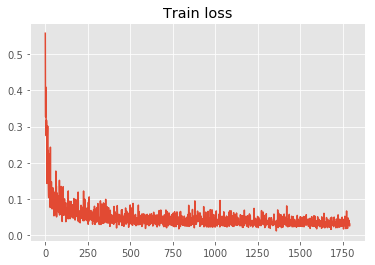

In [11]:
plt.plot(train_pipeline.get_variable('loss')[10:])
plt.title('Train loss');

## Model evaluation
Two models show approximately the same results but we recommend to use the second approach because it is more stable. For model performance assessment an [experiment](./parameters_estimation_2d_model.ipynb) was conducted on 20 model training launches from scratch.

Research results loading and a distribution for `test_mape30`:

In [12]:
res_table = Research().load('model_estimation/').load_results()
maximum = np.max(res_table['iteration'])
all_metrics = np.array(res_table[(res_table['iteration']==maximum) &
                                 (res_table['name']=='test_mape30')]['metrics'],
                       dtype=np.float32)

`Test_mape30` histogram

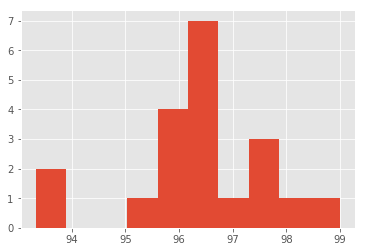

In [13]:
plt.hist(all_metrics)
plt.show()

In [14]:
df = Research().load('./model_estimation/').load_results(use_alias=True)
print_results_research(df, 'test_mape30', 'metrics',  average_repetitions=True,
                       sort_by='test_mape30_mean', n_last=50)

,test_mape30_mean,test_mape30_std
,96.52,0.308601


Average value (median) for the last 50 iterations: 96.52.

Now let's draw a histogram of distrubution of absolute error on test data

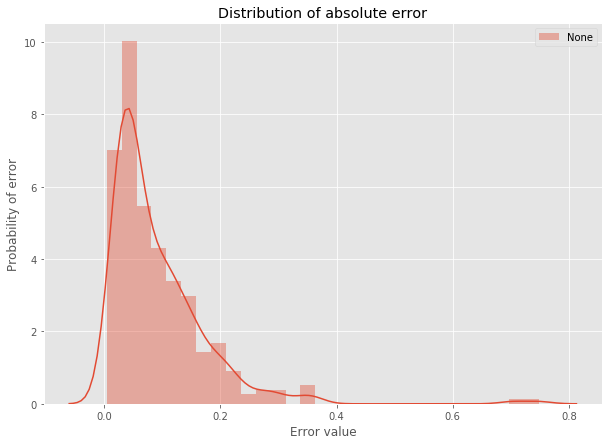

In [15]:
draw_hisogram(research='./model_estimation/', names='test_ape',
              type_var='metrics', cross_val=None)

## Inference

To make predictions on new data first we load time and derivarive data as numpy arrays of shape (n_items, ) with dtype object (because arrays for every item have different length).

In [16]:
new_log_data = np.load('/path/to/data/file.npz')
time = new_log_data['time']
derivative = new_log_data['derivative']

time = np.array([time] + [None])[:-1]
derivative = np.array([derivative] + [None])[:-1]

In [17]:
dataset = Dataset(index=1, batch_class=RadialBatch)

Preproccesing part loads the data from np.array, drops negative values, drops outliers, normalizes data and creates sample from the data of size 100 to feed the model.

Having trained model saved on some disk path `model_path` use the following pipeline to make preproccessing and get model prediction:

In [18]:
model_path = 'saved_model/'

predict_pipeline = (Pipeline()
                     .load(src=(time, derivative), components=['time', 'derivative'])
                     .drop_negative(src=['time', 'derivative'])
                     .drop_outliers(src=['time', 'derivative'])
                     .normalize(src=['time', 'derivative'],
                                dst_range=[None, 'derivative_q'])
                     .get_samples(100, sampler=np.random.random, src=['time', 'derivative'])
                     .make_points(src=['time', 'derivative'], dst=['points'])
                     .init_variable('predictions', init_on_each_run=list)
                     .init_model('dynamic', TFModel, 'model',
                                 config={'load' : {'path' : model_path},
                                         'build': False})
                     .init_variable('ind', init_on_each_run=list)
                     .update_variable('ind', B('indices'), mode='e')
                     .predict_model('model', fetches='predictions',
                                    feed_dict={'points': B('points')},
                                    save_to=B('predictions'), mode='w')
                     .clip_values(src=['predictions'])
                     .denormalize(src=['predictions'],
                                  src_range=['derivative_q'])
                     .update_variable('predictions', B('predictions'), mode='e')
                    ) << dataset

Batchflow pipeline object is lazy so to make it do the job we call its `run` method

In [19]:
predict_pipeline.run(1, n_epochs=10)

INFO:tensorflow:Restoring parameters from ../saved_model/model-1800


In [20]:
radial_mode = np.mean(np.array(predict_pipeline.get_variable('predictions')))

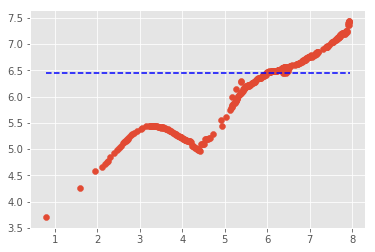

In [21]:
plt.scatter(time[0], derivative[0])
plt.hlines(radial_mode, min(time[0]), max(time[0]), linestyle='--', color='b')
plt.show()

To run predict pipeline outside notebook the file [predict.py](https://github.com/analysiscenter/radial/blob/modify_structure/prod/predict.py):

`python predict.py -p ./path/to/data.npy -m /path/to/model (optional)`

## Criticism

In this part we will take a look on the predictions vs real target values and compare them:

In [22]:
test_pipeline = create_predict_pipeline(prep_pipeline, './saved_model/') << ds_test

In [23]:
test_pipeline.run(1, n_epochs=10, drop_last=True, bar=True)

  0%|          | 0/900 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./saved_model/model-1801


100%|█████████▉| 899/900 [00:24<00:00, 37.34it/s]


Before drawing any of the examples of model prediction, they will be sorted by absolute value of percent errors(ape) and average.

In [24]:
results, names = calculate_results(test_pipeline)

#### Best predictions

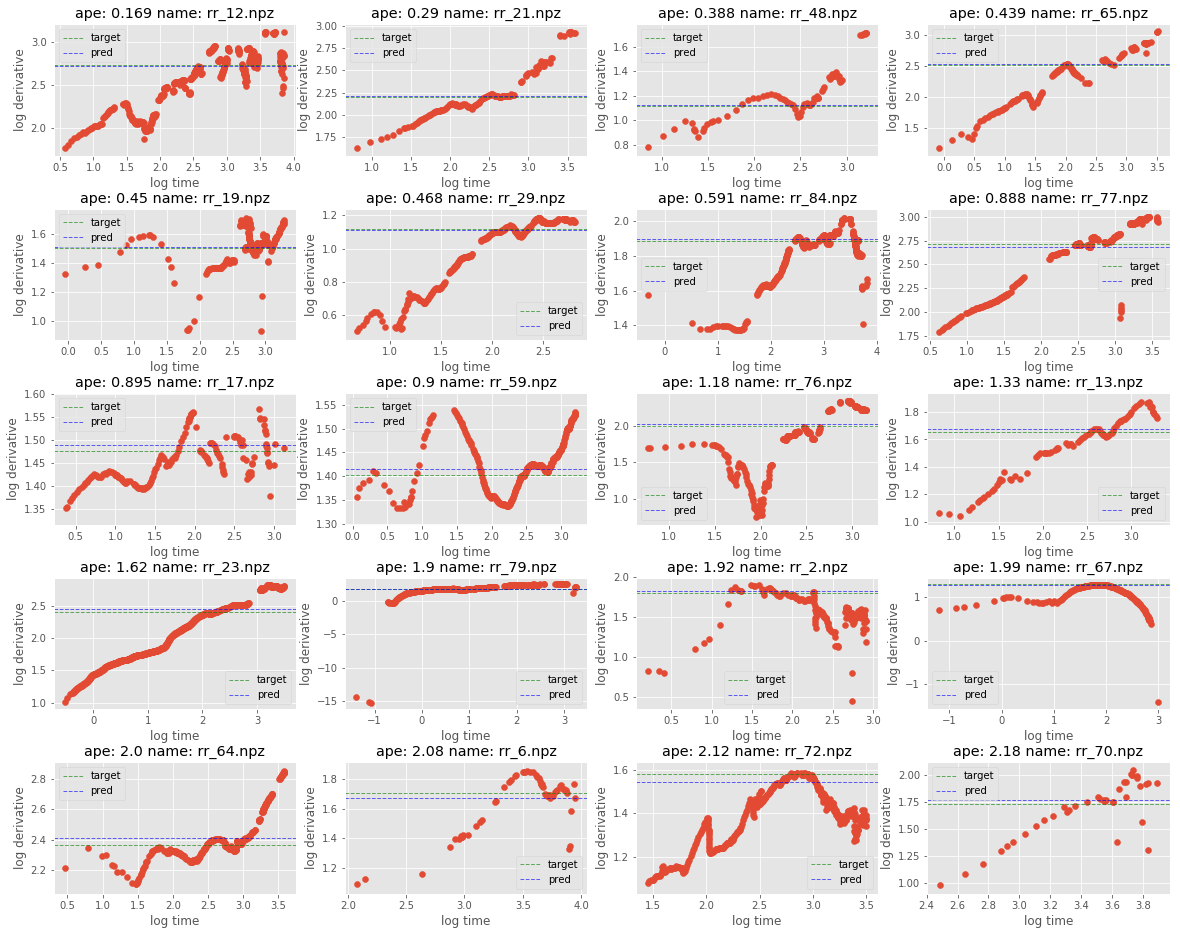

In [25]:
draw_predictions(results, names[:20], path="./data_splited/test_isol/")

#### Worst predictions

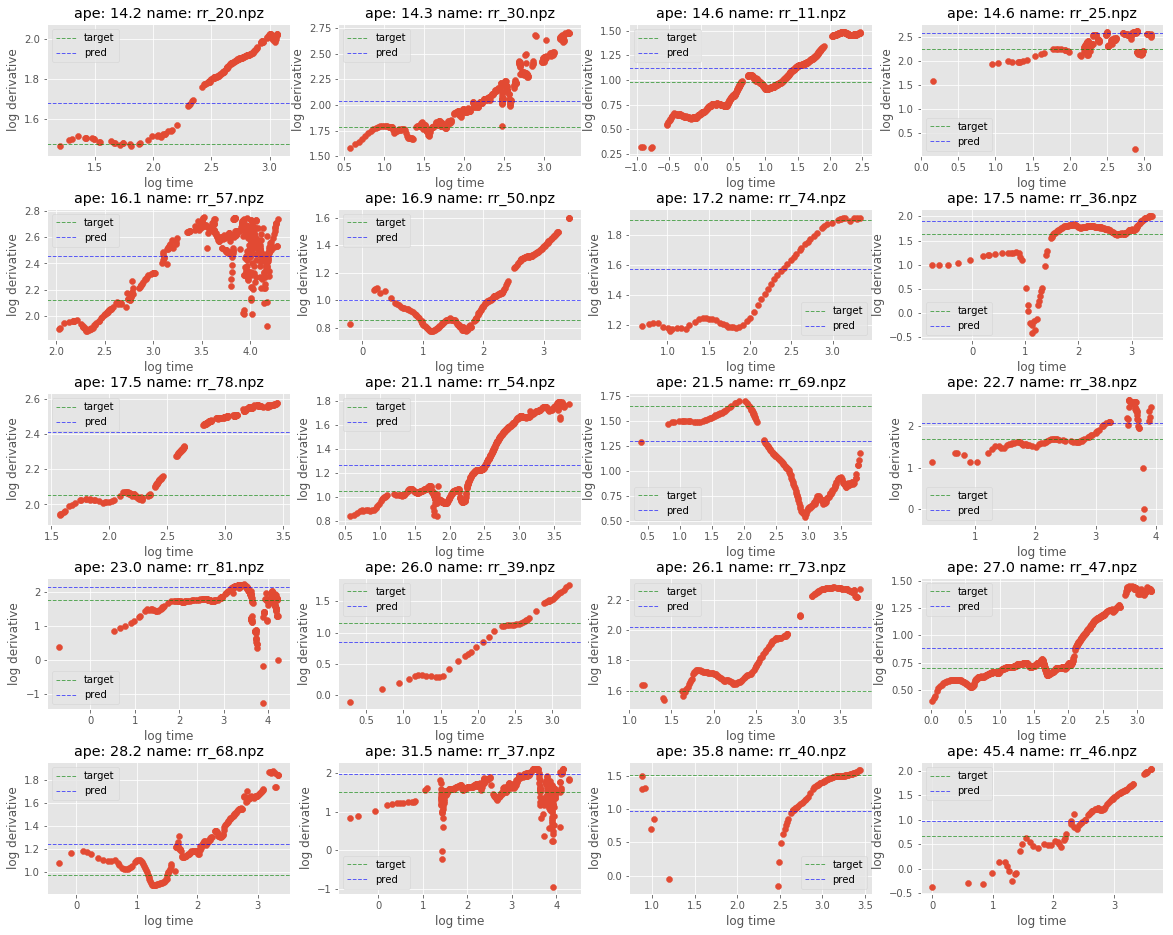

In [26]:
draw_predictions(results, names[-20:], path="./data_splited/test_isol/")

As you can see predictions in simple cases are quite accurate but there are cases when model predicts another horizontal value. Also, there is still space for improving denoising step (these plots illustarate already denoised data in log-log axes).

## Summary
The model predicts a position of the radial mode according to the pressure derivative vs time data. The mean metrics value that corresponding to a percentage of items with absolute percentage error less than 30% is 96.52 for the 2d model and the std of this model is 0.3086.

## Proposals for the improvement and further development

The following methods could improve the quality of the model:
* using sampling that depends on number of points in small area instead of uniform distribution
* using another methods of denoising and another method of interpolation instead of piecewise linear interpolation
* using another optimizer
* building an ensemble of models
* adding new data for training.